In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec #Useful tool to arrange multiple plots in one figure (https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html)

%matplotlib inline

import platform
platstring = platform.platform()

data_dirname = 'visual-behavior-neuropixels'
use_static = False
if 'Darwin' in platstring or 'macOS' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2021/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/"
    data_dirname = 'visual-behavior-neuropixels-data'
    use_static = True
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/home/andrew/Documents/tmp/5-1-24-change-detection"

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# this path determines where downloaded data will be stored
manifest_path = os.path.join(data_root, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

print(cache.get_all_session_types())



/home/andrew/Documents/projects/swdb_2022/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['brain_observatory_1.1', 'functional_connectivity']


In [4]:
# IMPORTANT: how flashes to ignore
flashes_ignore = 3
num_sessions = 600

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def get_time_window(session, buffer=1):
    """
    Get the time window from slightly before the first flash to slightly after the third flash.
    
    Parameters:
        session (EcephysSession): The session object.
        buffer (float): Buffer time in seconds to extend before the first and after the last flash.
    
    Returns:
        tuple: start_time, end_time
    """
    num_flashes = 50
    flashes = session.get_stimulus_table("flashes").head(num_flashes)

    print("number of flashes!!!-------------")
    print(len(flashes))
    if len(flashes) != num_flashes:
        print("++++++++++++++++++BIG BIG ISSUE NUM FLASHES NOT CONSISTENT")
        exit(1)

    num_flashes = min(num_flashes, len(flashes))
    start_time = flashes.iloc[0]['start_time'] - buffer
    end_time = flashes.iloc[num_flashes-1]['stop_time'] + buffer

    flash_start_times = flashes['start_time'].values
    flash_end_times = flashes['stop_time'].values

    print("number of flash starts")
    print(len(flash_start_times))
    print("number of flash ends")
    print(len(flash_end_times))
    if len(flash_start_times) != len(flash_end_times) and len(flash_start_times) != num_flashes:
        print("++++++++++++++++++BIG BIG ISSUE NUM FLASHES NOT CONSISTENT")
        exit(1)

    return start_time, end_time, flash_start_times, flash_end_times

sessions = cache.get_session_table()
selected_sessions = sessions.head(num_sessions)  # Select only the first two sessions

regions = ["LGd", "LGv", "LP", "VISp", "VISl", "VISal", "VISrl", "VISpm", "VISam"]
bin_size = 0.005  # Example bin size of 100ms

max_start_time = 0
for count, session_id in enumerate(selected_sessions.index):
    # get session
    session = cache.get_session_data(session_id)

    start_time, end_time, flash_start_times, flash_end_times = get_time_window(session)

    if start_time > max_start_time:
        max_start_time = start_time


# TODO: problem is that the flash start times don't line up and we are using an
# arbitrary one. Previously we binned soon after this loop starts, which means
# things line up. But now that we jut aggregate neural activity per time it does
# not add up. This is why you see things line up for one session but not for
# multiple.
region_to_spikes = {region: [] for region in regions}
region_unit_counts = {region: 0 for region in regions}
all_flash_starts = []
all_flash_ends = []
for count, session_id in enumerate(selected_sessions.index):
    # get session
    session = cache.get_session_data(session_id)

    start_time, end_time, flash_start_times, flash_end_times = get_time_window(session)

    offset = max_start_time - start_time
    start_time = start_time + offset
    end_time = end_time + offset
    flash_start_times = flash_start_times + offset
    flash_end_times = flash_end_times + offset

    # get all spikes for every unit (unit -> spikes), group by region
    for unit_id, spikes in session.spike_times.items():
        region = session.units.loc[unit_id, 'ecephys_structure_acronym']
        if region in regions:
            spikes = spikes + offset
            # check if spike time within the start and end time
            spikes = spikes[(spikes >= start_time) & (spikes <= end_time)]

            # if the number of units in a region is < 30, skip this region
            if len(spikes) < 30:
                continue

            region_to_spikes[region].append(spikes)
            region_unit_counts[region] += 1

    # bin the flash start times and end times
    flash_starts_binned = np.histogram(flash_start_times, bins=np.arange(start_time, end_time, bin_size))[0]
    flash_ends_binned = np.histogram(flash_end_times, bins=np.arange(start_time, end_time, bin_size))[0]

    all_flash_starts.append(flash_starts_binned)
    all_flash_ends.append(flash_ends_binned)

# iterate over all regions
# bin data for each region
# normalize by number of units for each region
all_region_data = {}
for region, spikes in region_to_spikes.items():
    if len(spikes) == 0:
        print("ERROR: No spikes for region", region)
        continue
        # IMPORTANT: uncomment when working
        # exit(1)

    print(region)
    spikes = np.concatenate(spikes)
    spikes = np.histogram(spikes, bins=np.arange(start_time, end_time, bin_size))[0]
    spikes_norm = spikes / region_unit_counts[region]

    all_region_data[region] = spikes_norm

average_flash_starts = np.mean(all_flash_starts, axis=0)
average_flash_ends = np.mean(all_flash_ends, axis=0)
num_time_steps_before_first_flash = np.where(average_flash_starts == 1)[0][0]
num_time_steps_after_last_flash = len(average_flash_starts) - np.where(average_flash_starts == 1)[0][-1]

flash_indices = np.where(average_flash_starts == 1)[0]
num_flashes = len(flash_indices)
print("num flashes after averaging: ", num_flashes)
chunk_size = num_time_steps_before_first_flash + num_time_steps_after_last_flash

# calculate std_err
# bin the spike times by session
# now we have shape (num_regions, num_sessions, num_bins)
# overlap the chunks for each session on top of each other, so now we have shape (num_regions, num_bins/chunk_size * num_sessions, chunk_size)
std_err_data = {}
for region, spikes in all_region_data.items():
    if len(spikes) == 0:
        print("ERROR: No spikes for region", region)
        continue
        # IMPORTANT: uncomment when working
        # exit(1)

    region_spikes = []
    for spikes in region_to_spikes[region]:
        # print("------")
        # print(spikes)
        # print("++++++++++++=")
        spikes = np.histogram(spikes, bins=np.arange(start_time, end_time, bin_size))[0]
        # print(spikes)
        # print("------")
        # print()
        spikes = pd.Series(spikes)
        region_spikes.append(spikes)
    
    region_spikes = pd.concat(region_spikes, axis=1)
    print(region_spikes.shape)

    # go through all the flash indices and append the chunk of data
    overlaid_chunks_0 = []
    for index, spikes_binned in region_spikes.items():
        for i in range(flashes_ignore, num_flashes):
            start_index = flash_indices[i] - num_time_steps_before_first_flash
            end_index = start_index + chunk_size
            chunk = pd.Series(spikes_binned[start_index:end_index])
            chunk.reset_index(drop=True, inplace=True)
            overlaid_chunks_0.append(chunk)
        # print(chunk.shape)

    print(len(overlaid_chunks_0))
    print(len(overlaid_chunks_0[0]))

    overlaid_chunks_concat_0 = pd.concat(overlaid_chunks_0, axis=1, ignore_index=True)

    print("-------")
    print(overlaid_chunks_concat_0.shape)

    # shape of overlaid_chunks will be (chunk_size, num_bins / chunk_size * num_sessions)
    # calculate the std_err to eliminate the second dimension
    std_err = overlaid_chunks_concat_0.std(axis=1) / np.sqrt(overlaid_chunks_concat_0.shape[1])
    std_err_data[region] = std_err

    print(std_err_data[region].shape)
        
"""
Normalization
I get the problem you are mentioning in your previous email (the 100% fall off from the trace going below baseline). I think your normalization still has some issues. If the final metric you want to show is the bar plot which is effectively a time-to-threshold metric, then the initial and final point of all the traces needs to be better normalized. Clamping the baseline to zero is not enough, I think that also the peak of each trace needs to be clamped as well, so that the range the traces span over the course of time is identical. I suggest the following:
- set the baseline of each time-series to the average baseline across baselines. In your plots it is currently set to zero, instead set it to the average across areas. This should also resolve the issue you mentioned above (100% of fall of when going below zero).
- set the peak of each time series to the average peak across traces. 
The total transformation should be something like this: normalized-trace = (trace-b+<b>) * (<p>-<b>)/(p-b)
where p, b are the peak and baseline of a single trace and <p>, <b> are the averages across traces for peak and baseline respectively. While you have only one baseline in each trace, for the peak you have two (stimulus onset and stimulus offset). You need to select the peak according to the interval you analyze.
After this normalization the speed of the trace is effectively normalized to the overall range they cover, and the  time-to-threshold should have less idiosyncratic effects.
"""


/home/andrew/Documents/projects/swdb_2022/env/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/andrew/Documents/projects/swdb_2022/env/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)


number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
number of flashes!!!-------------
50
number

'\nNormalization\nI get the problem you are mentioning in your previous email (the 100% fall off from the trace going below baseline). I think your normalization still has some issues. If the final metric you want to show is the bar plot which is effectively a time-to-threshold metric, then the initial and final point of all the traces needs to be better normalized. Clamping the baseline to zero is not enough, I think that also the peak of each trace needs to be clamped as well, so that the range the traces span over the course of time is identical. I suggest the following:\n- set the baseline of each time-series to the average baseline across baselines. In your plots it is currently set to zero, instead set it to the average across areas. This should also resolve the issue you mentioned above (100% of fall of when going below zero).\n- set the peak of each time series to the average peak across traces. \nThe total transformation should be something like this: normalized-trace = (trace

(449,)
(449,)
(449,)
(449,)
(449,)
(449,)
(449,)
(449,)
(449,)
(449,)
(449,)


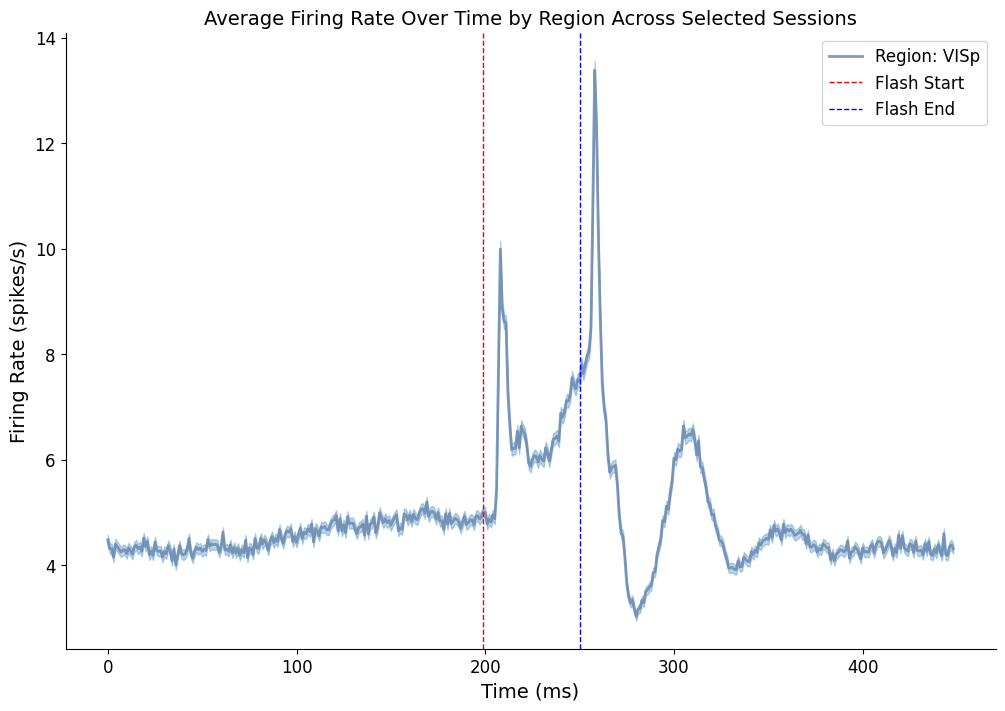

(449,)
(449,)


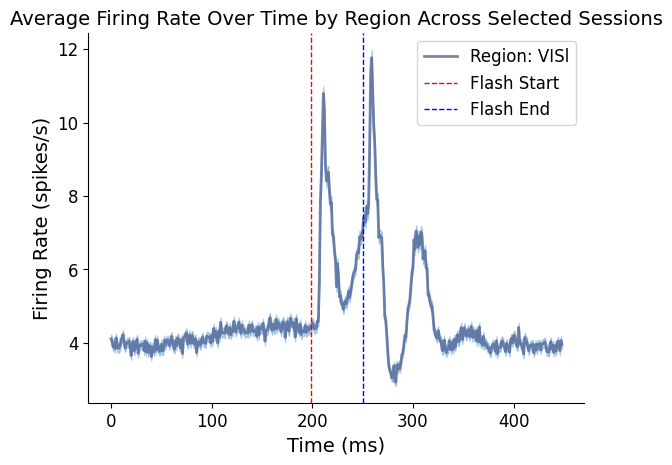

(449,)
(449,)


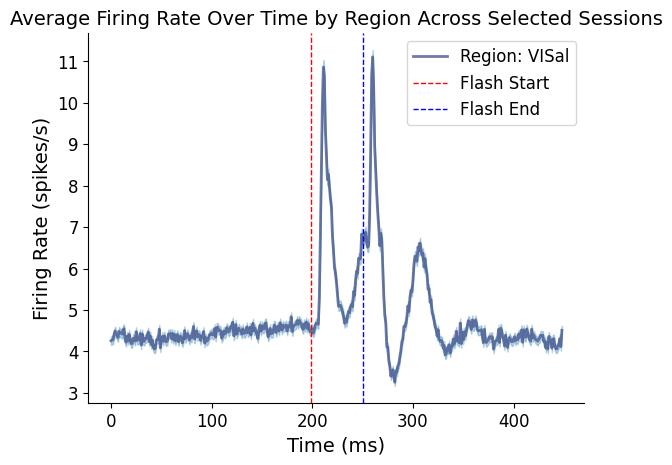

(449,)
(449,)


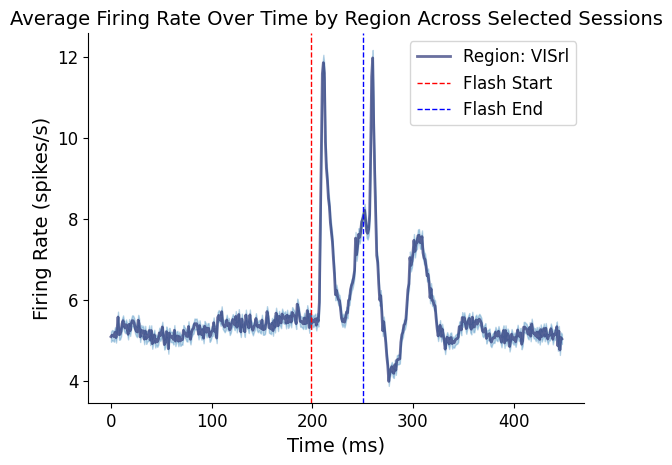

(449,)
(449,)


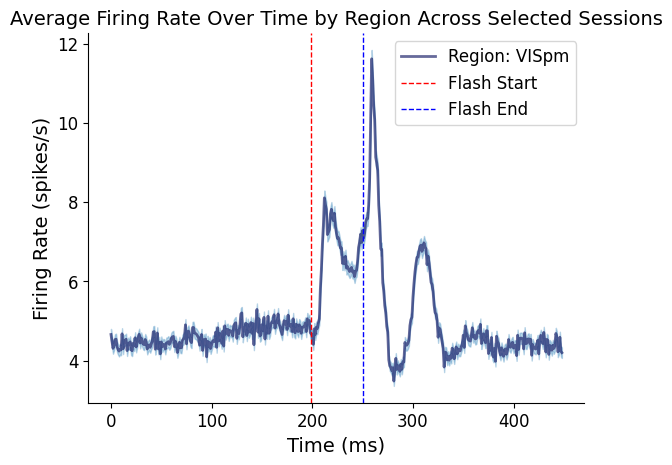

(449,)
(449,)


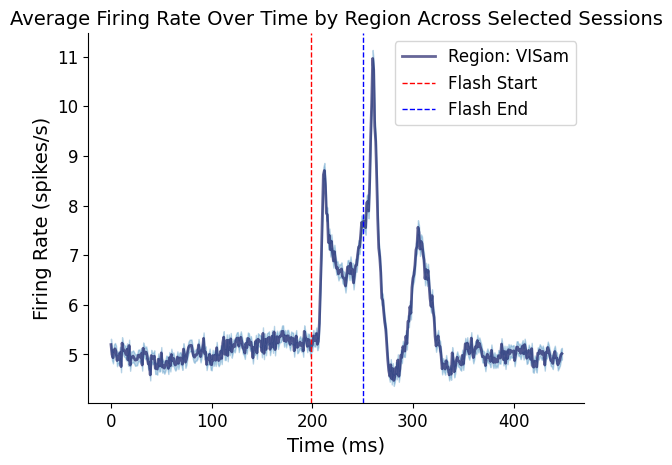

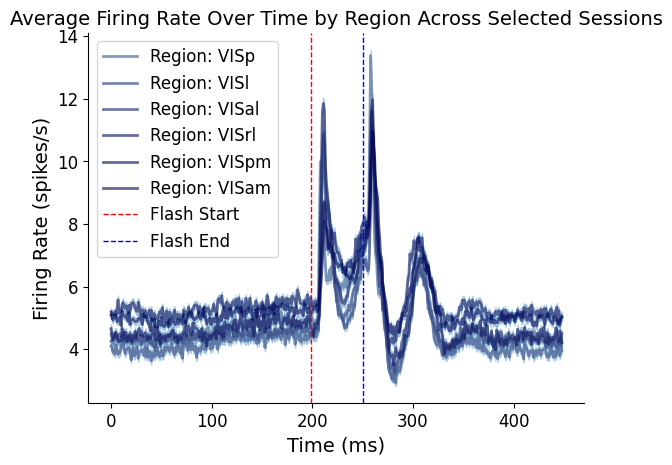

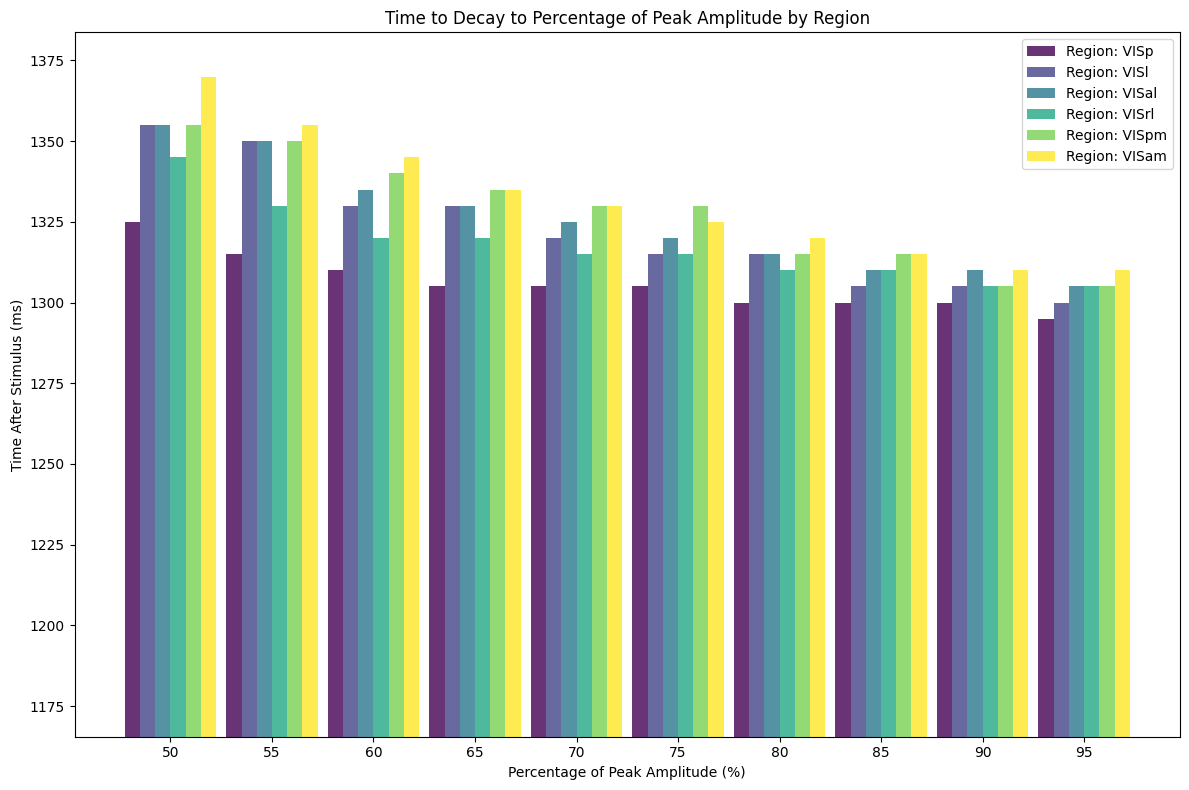

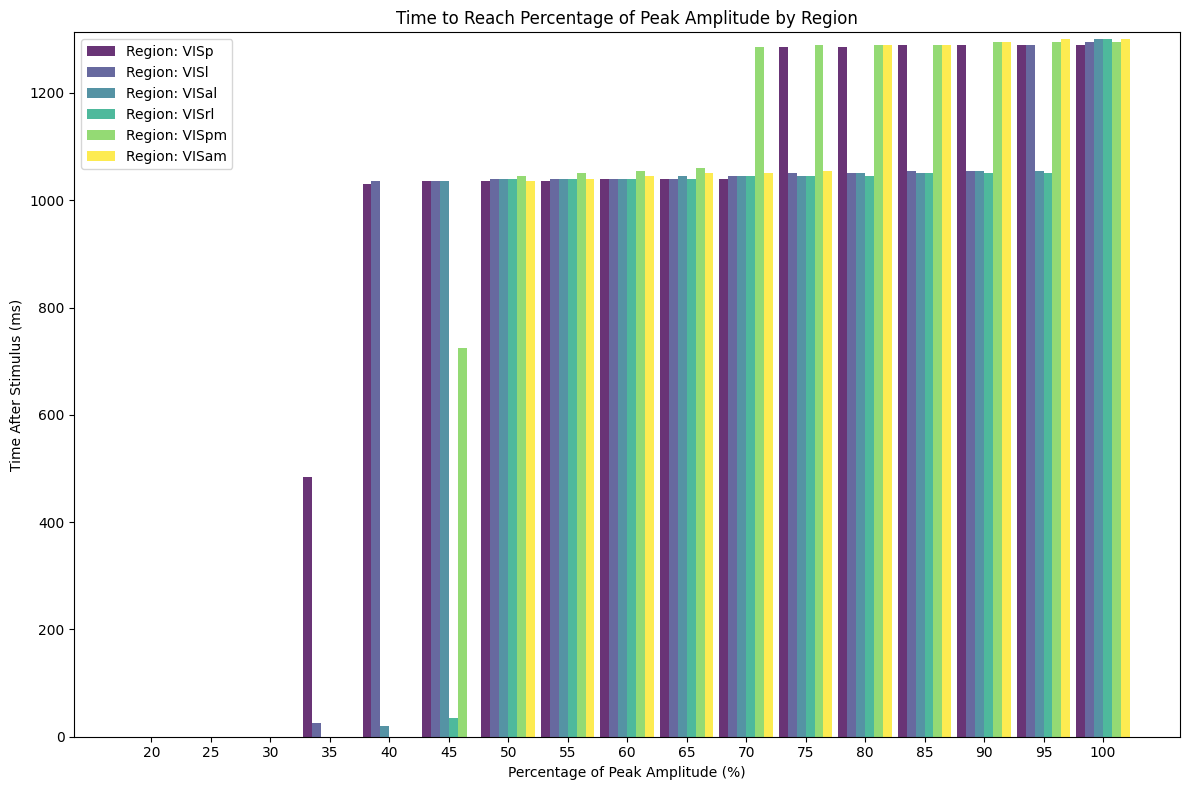

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_rgba

# ALL
start_bin = 0
end_bin = 10000

# FLASH ON RISE
# start_bin = 203
# end_bin = 232

# FLASH ON FALL
# start_bin = 208
# end_bin = 242

# FLASH OFF RISE
# start_bin = 230
# end_bin = 262

# FLASH OFF FALL
# start_bin = 257 * 1
# end_bin = 280 * 1

# SECOND SPIKE RISE
# start_bin = 275
# end_bin = 315

# SECOND SPIKE FALL
# start_bin = 295
# end_bin = 350

def plot_firing_rates(region_data, bin_size, average_flash_starts, average_flash_ends, flash_offset, std_err_data):
    """
    Plot the firing rates over time for each region, ensuring data alignment,
    and add vertical lines for average flash starts and ends based on a binary indicator.

    Parameters:
        region_data (dict): Dictionary containing firing rates binned over time for each region.
        bin_size (float): Bin size used in seconds.
        average_flash_starts (array): Array of binary values indicating flash starts.
        average_flash_ends (array): Array of binary values indicating flash ends.
        flash_offset (float): Offset to align the flash indicators correctly with the time bins.
    """
    # print(average_flash_starts - average_flash_ends)
    plt.figure(figsize=(12, 8))

    # Define a blue colormap that scales from dark to light
    # colors = LinearSegmentedColormap.from_list("blue_grad", ["#1f77b4", "#08306b"], N=len(region_data))
    # color_map = {region: colors(i / len(region_data)) for i, region in enumerate(region_data.keys())}

    # Get the original darkblue color
    darkblue = to_rgba("darkblue")

    # Calculate the new darkblue color with 60% intensity
    new_darkblue = tuple(0.6 * c for c in darkblue)

    # Create the modified colormap
    colors = LinearSegmentedColormap.from_list("blue_grad", ["lightblue", new_darkblue], N=20)

    # colors = LinearSegmentedColormap.from_list("blue_grad", ["lightblue", "darkblue"], N=20)

    color_map = {region: colors(i / (len(region_data) - 1)) for i, region in enumerate(region_data.keys())}
    # color_map = {region: colors(i) for i, region in enumerate(regions)}

    regions_for_fn = ["VISp", "VISl", "VISal", "VISrl", "VISpm", "VISam"]

    for region_0 in regions_for_fn:
        for i, (region, data) in enumerate(region_data.items()):
            if region not in [region_0]:
                continue

            if not data.empty:
                time_bins = np.linspace(data.index[0], data.index[-1], num=len(data))
                sliced_time_bins = time_bins[start_bin:end_bin]
                # sliced_time_bins = (time_bins - time_bins[start_bin]) * bin_size * 1000
                sliced_data = data.values[start_bin:end_bin] / bin_size
                
                std_err_for_region = std_err_data[region].values[start_bin:end_bin] / bin_size

                print(sliced_data.shape)
                print(std_err_for_region.shape)

                plt.plot(sliced_time_bins, sliced_data, label=f'Region: {region}', color=color_map[region], linewidth=2)
                plt.fill_between(sliced_time_bins, sliced_data - std_err_for_region, sliced_data + std_err_for_region, alpha=0.3, color="#1f77b4")
            else:
                print(f"No data available for region {region}")

        average_flash_starts = average_flash_starts
        average_flash_ends = average_flash_ends

        for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts[start_bin:end_bin], average_flash_ends[start_bin:end_bin])):
            if flash_start == 1:
                plt.axvline(x=flash_offset + bin_num + start_bin, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
            if flash_end == 1:
                plt.axvline(x=flash_offset + bin_num + start_bin, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

        plt.xlabel('Time (ms)', fontsize=14)
        plt.ylabel('Firing Rate (spikes/s)', fontsize=14)
        plt.title('Average Firing Rate Over Time by Region Across Selected Sessions', fontsize=14)
        plt.legend(fontsize=12)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.grid(False)
        plt.show()

    for i, (region, data) in enumerate(region_data.items()):
        if region not in regions_for_fn:
            continue

        if not data.empty:
            time_bins = np.linspace(data.index[0], data.index[-1], num=len(data))
            sliced_time_bins = time_bins[start_bin:end_bin]
            # sliced_time_bins = (time_bins - time_bins[start_bin]) * bin_size * 1000
            sliced_data = data.values[start_bin:end_bin] / bin_size
            std_err = std_err_data[region].values[start_bin:end_bin] / bin_size

            plt.plot(sliced_time_bins, sliced_data, label=f'Region: {region}', color=color_map[region], linewidth=2)
            plt.fill_between(sliced_time_bins, sliced_data - std_err, sliced_data + std_err, alpha=0.3, color="#1f77b4")
        else:
            print(f"No data available for region {region}")

    # for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts_for_fn[start_bin:end_bin], average_flash_ends_for_fn[start_bin:end_bin])):
    #     if flash_start == 1:
    #         plt.axvline(x=flash_offset + bin_num * 5, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
    #     if flash_end == 1:
    #         plt.axvline(x=flash_offset + bin_num * 5, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

    for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts[start_bin:end_bin], average_flash_ends[start_bin:end_bin])):
        if flash_start == 1:
            plt.axvline(x=flash_offset + bin_num + start_bin, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
        if flash_end == 1:
            plt.axvline(x=flash_offset + bin_num + start_bin, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('Time (ms)', fontsize=14)
    plt.ylabel('Firing Rate (spikes/s)', fontsize=14)
    plt.title('Average Firing Rate Over Time by Region Across Selected Sessions', fontsize=14)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(False)
    plt.show()

overlaid_region_data = {}
# for region in regions:
for region in all_region_data.keys():
    overlaid_chunks = []
    for i in range(flashes_ignore, num_flashes):
        start_index = flash_indices[i] - num_time_steps_before_first_flash
        end_index = start_index + chunk_size
        chunk = pd.Series(all_region_data[region][start_index:end_index])
        overlaid_chunks.append(chunk)

    overlaid_chunks_concat = pd.concat(overlaid_chunks, axis=1)
    num_chunks = overlaid_chunks_concat.shape[1]
    overlaid_chunks_sum = overlaid_chunks_concat.sum(axis=1)
    for i in range(len(overlaid_chunks_sum)):
        overlaid_chunks_sum[i] = overlaid_chunks_sum[i] / (num_chunks)

    overlaid_region_data[region] = overlaid_chunks_sum


for region in overlaid_region_data.keys():
    print(overlaid_region_data[region].shape)

average_flash_starts = average_flash_starts[0:chunk_size]
average_flash_ends = average_flash_ends[0:chunk_size]
plot_firing_rates(overlaid_region_data, bin_size, average_flash_starts, average_flash_ends, flash_offset=0, std_err_data=std_err_data)

################################################################

def find_peak_amplitude(data, margin):
    max_value = data.max()
    peak_amplitude = max_value
    for i in range(len(data) - 1, -1, -1):
        if data.iloc[i] >= max_value - margin:
            peak_amplitude = data.iloc[i]
            break
    return peak_amplitude

def find_time_to_percent_peak(data, peak_value, percent, start_bin, end_bin):
    target_value = peak_value * percent
    peak_reached = False
    for i in range(len(data)):
        if not peak_reached and data.iloc[i] == peak_value:
            peak_reached = True
        if peak_reached and data.iloc[i] <= target_value:
            return data.index[i]
    return -1

margin = 0.0000  # Adjust this value according to your needs

plt.figure(figsize=(12, 8))

percentages = np.arange(0.50, 0.96, 0.05)
bar_width = 0.15
opacity = 0.8

regions = ["VISp", "VISl", "VISal", "VISrl", "VISpm", "VISam"]
colors = plt.cm.viridis(np.linspace(0, 1, len(regions)))

all_time_to_percent_peak = []

for i, region in enumerate(regions):
    # # IMPORTANT: remove when working
    # if region not in overlaid_region_data or overlaid_region_data[region].empty:
    #     continue

    data = overlaid_region_data[region]
    sliced_data = data[start_bin:end_bin]
    peak_amplitude = find_peak_amplitude(sliced_data, margin)
    time_to_percent_peak = []

    for percent in percentages:
        time = find_time_to_percent_peak(sliced_data, peak_amplitude, percent, start_bin, end_bin)
        if time != -1:
            time_to_percent_peak.append((time) * bin_size * 1000)
        else:
            time_to_percent_peak.append(np.nan)

    all_time_to_percent_peak.append(time_to_percent_peak)
    index = np.arange(len(percentages))
    plt.bar(index + i * bar_width, time_to_percent_peak, bar_width, alpha=opacity, color=colors[i], label=f'Region: {region}')

# Adjust y-axis based on the range of values in all_time_to_percent_peak
all_time_to_percent_peak_flat = [item for sublist in all_time_to_percent_peak for item in sublist if not np.isnan(item)]
y_min = min(all_time_to_percent_peak_flat) * 0.9
y_max = max(all_time_to_percent_peak_flat) * 1.01
plt.ylim(y_min, y_max)

plt.xlabel('Percentage of Peak Amplitude (%)')
plt.ylabel('Time After Stimulus (ms)')
plt.title('Time to Decay to Percentage of Peak Amplitude by Region')
plt.xticks(index + bar_width * (len(regions) - 1) / 2, (percentages * 100).astype(int))
plt.legend()
plt.tight_layout()
plt.show()

############################################################################################

def find_time_to_percent_peak(data, peak_value, percent):
    target_value = peak_value * percent
    for i in range(len(data)):
        if data.iloc[i] >= target_value:
            return data.index[i]
    return -1

# Define percentages
percentages_to_peak = np.linspace(0.20, 1.00, 17)  # Generates 17 evenly spaced values from 0.20 to 1.00


# Create the bar plot for time to reach percentage of peak
plt.figure(figsize=(12, 8))
bar_width = 0.15
opacity = 0.8
colors = plt.cm.viridis(np.linspace(0, 1, len(regions)))

all_time_to_percent_peak = []

for i, region in enumerate(regions):
    # IMPORTANT: remove when working 
    if region not in overlaid_region_data or overlaid_region_data[region].empty:
        continue

    data = overlaid_region_data[region]
    sliced_data = data[start_bin:end_bin]
    peak_value = sliced_data.max()
    time_to_percent_peak = []

    for percent in percentages_to_peak:
        time = find_time_to_percent_peak(sliced_data, peak_value, percent)
        if time != -1:
            time_to_percent_peak.append((time) * bin_size * 1000)
        else:
            time_to_percent_peak.append(np.nan)

    all_time_to_percent_peak.append(time_to_percent_peak)
    index = np.arange(len(percentages_to_peak))
    plt.bar(index + i * bar_width, time_to_percent_peak, bar_width, alpha=opacity, color=colors[i], label=f'Region: {region}')

# Adjust y-axis based on the range of values in all_time_to_percent_peak
all_time_to_percent_peak_flat = [item for sublist in all_time_to_percent_peak for item in sublist if not np.isnan(item)]
y_min = min(all_time_to_percent_peak_flat) * 0.97
y_max = max(all_time_to_percent_peak_flat) * 1.01
plt.ylim(y_min, y_max)

plt.xlabel('Percentage of Peak Amplitude (%)')
plt.ylabel('Time After Stimulus (ms)')
plt.title('Time to Reach Percentage of Peak Amplitude by Region')
plt.xticks(index + bar_width * (len(regions) - 1) / 2, (percentages_to_peak * 100).astype(int))
plt.legend()
plt.tight_layout()
plt.show()

449
449
---------
449
(23,)
(23,)
(23,)


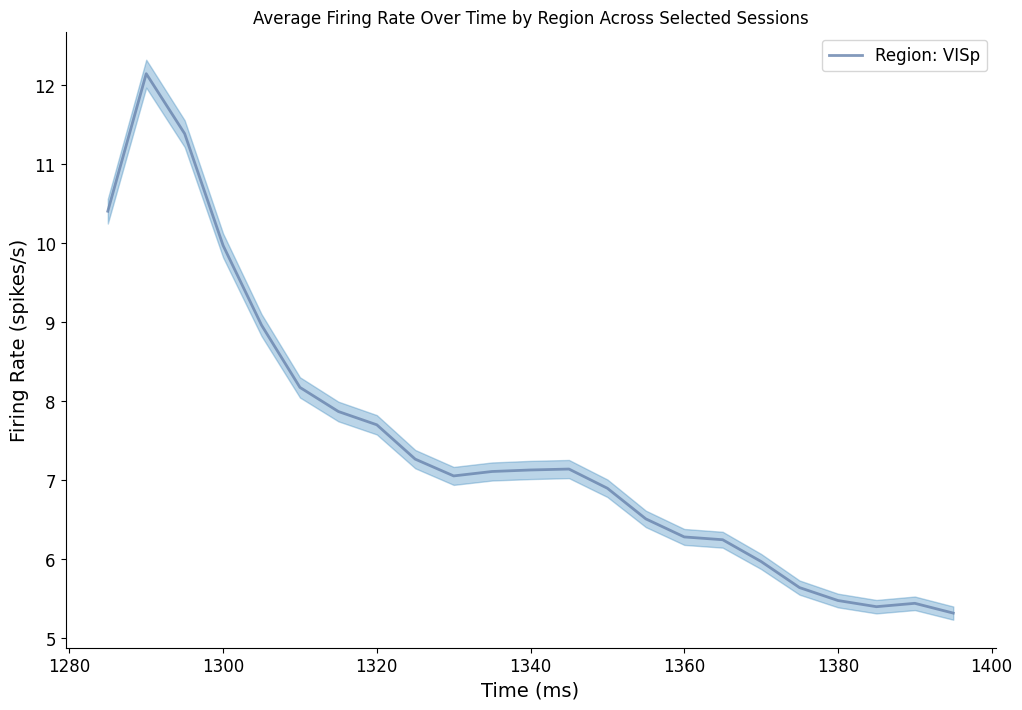

---------
449
(23,)
(23,)
(23,)


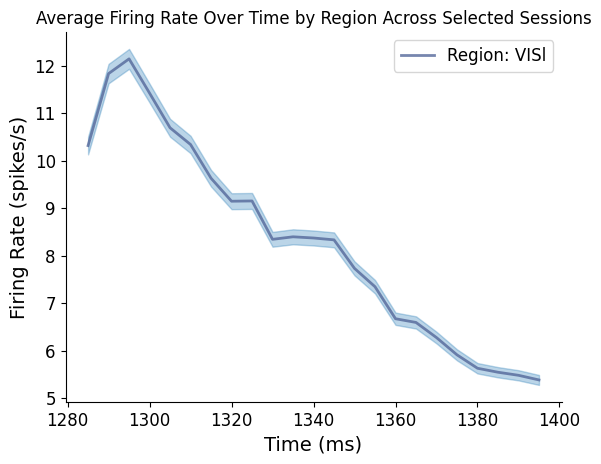

---------
449
(23,)
(23,)
(23,)


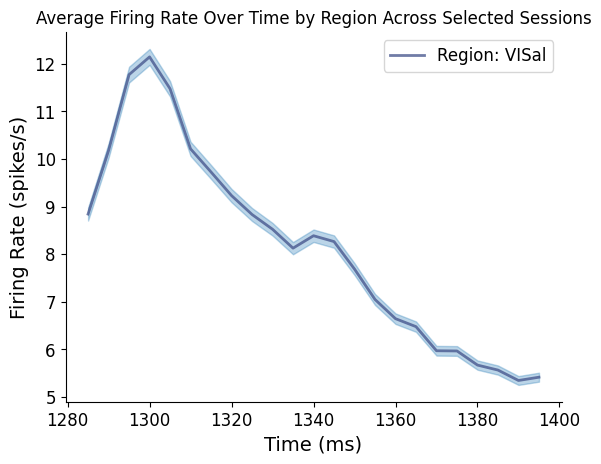

---------
449
(23,)
(23,)
(23,)


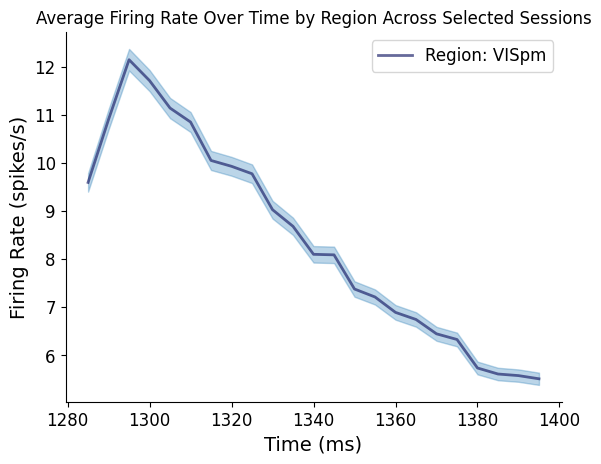

---------
449
(23,)
(23,)
(23,)


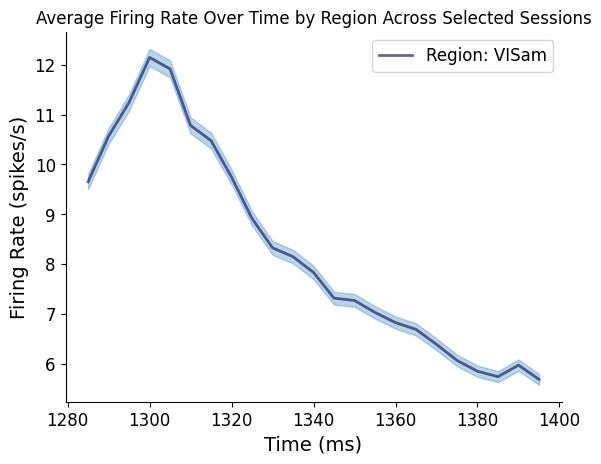

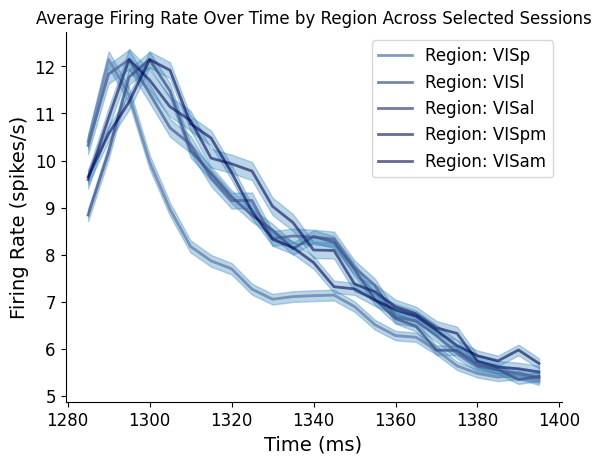

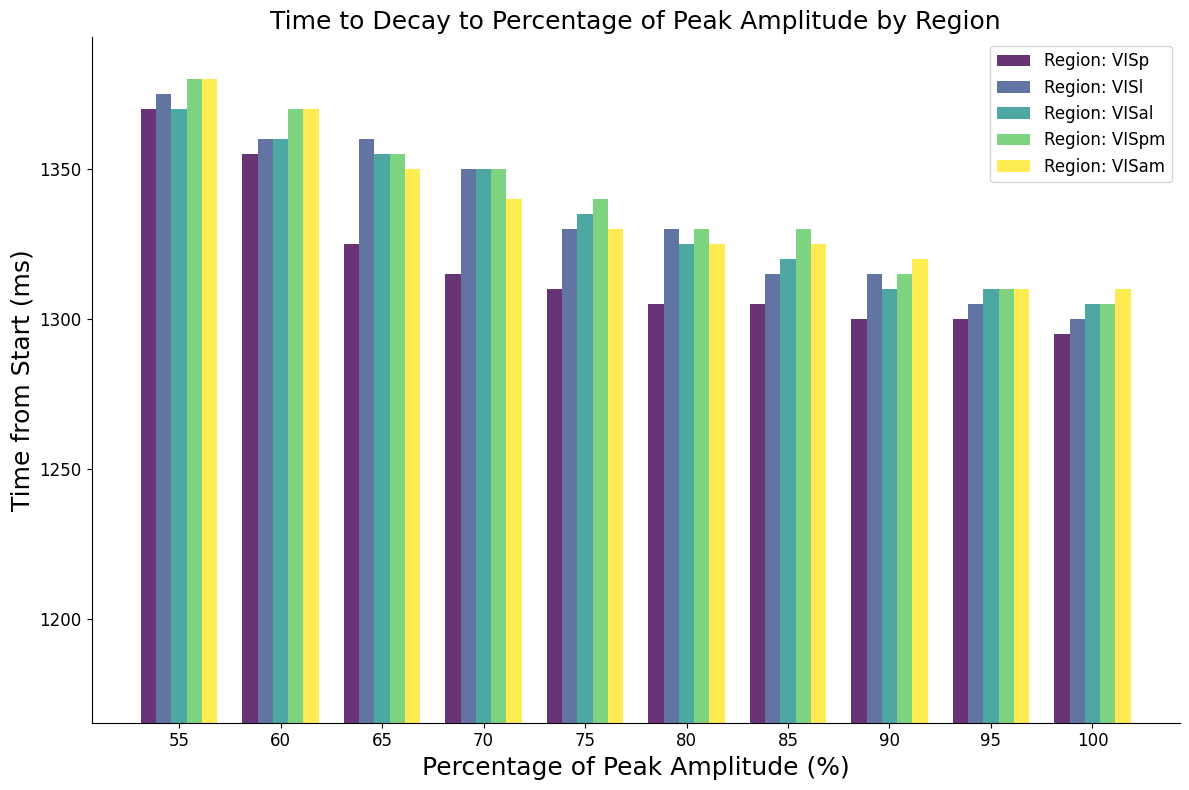

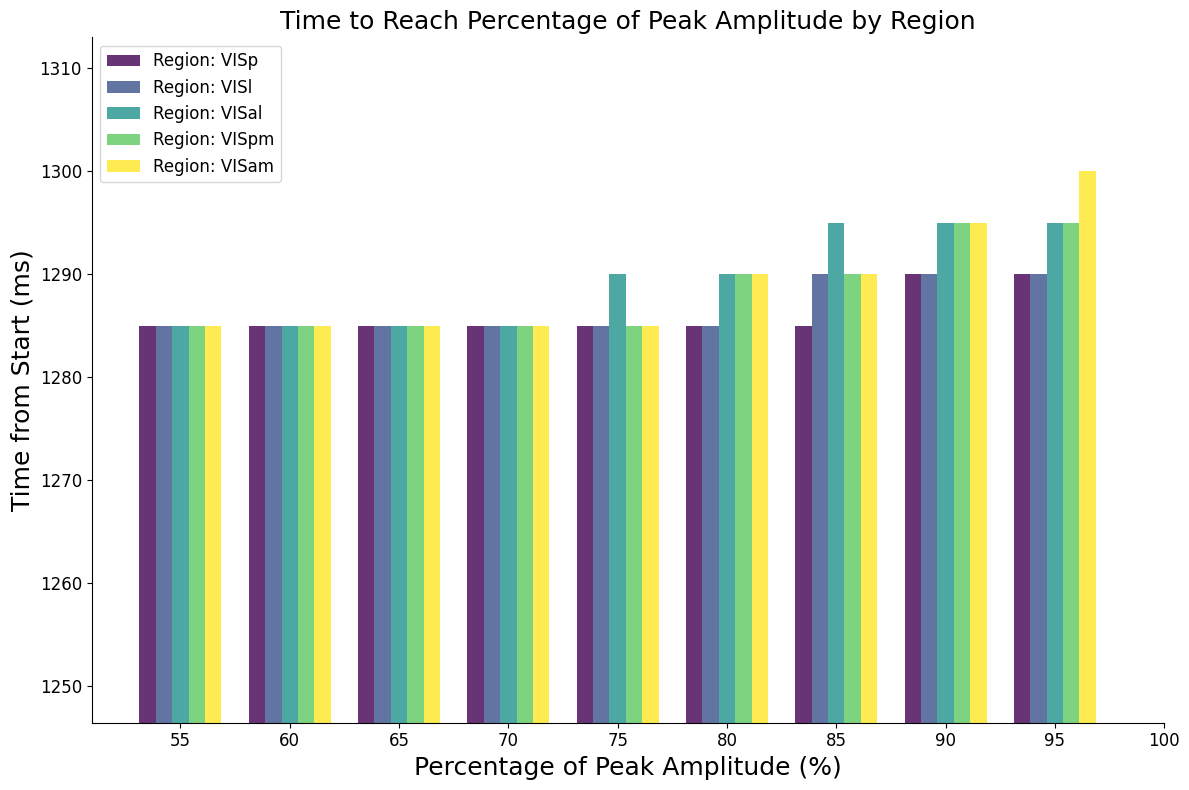

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_rgba

# ALL
# start_bin = 0
# end_bin = 10000

# FLASH ON RISE
start_bin = 203
end_bin = 232

# FLASH ON FALL
# start_bin = 206
# end_bin = 244

# FLASH OFF RISE
# start_bin = 230
# end_bin = 262

# FLASH OFF FALL
# start_bin = 257 * 1
# end_bin = 280 * 1

# SECOND SPIKE RISE
# start_bin = 275
# end_bin = 315

# SECOND SPIKE FALL
# start_bin = 295
# end_bin = 350

def plot_firing_rates(region_data, region_data_initial, bin_size, average_flash_starts, average_flash_ends, flash_offset, std_err_data):
    """
    Plot the firing rates over time for each region, ensuring data alignment,
    and add vertical lines for average flash starts and ends based on a binary indicator.

    Parameters:
        region_data (dict): Dictionary containing firing rates binned over time for each region.
        bin_size (float): Bin size used in seconds.
        average_flash_starts (array): Array of binary values indicating flash starts.
        average_flash_ends (array): Array of binary values indicating flash ends.
        flash_offset (float): Offset to align the flash indicators correctly with the time bins.
    """
    # print(average_flash_starts - average_flash_ends)
    plt.figure(figsize=(12, 8))

    # Define a blue colormap that scales from dark to light
    # colors = LinearSegmentedColormap.from_list("blue_grad", ["#1f77b4", "#08306b"], N=len(region_data))
    # color_map = {region: colors(i / len(region_data)) for i, region in enumerate(region_data.keys())}

    # Get the original darkblue color
    darkblue = to_rgba("darkblue")

    # Calculate the new darkblue color with 60% intensity
    new_darkblue = tuple(0.6 * c for c in darkblue)

    # Create the modified colormap
    colors = LinearSegmentedColormap.from_list("blue_grad", ["lightblue", new_darkblue], N=20)

    # colors = LinearSegmentedColormap.from_list("blue_grad", ["lightblue", "darkblue"], N=20)

    color_map = {region: colors(i / (len(region_data) - 1)) for i, region in enumerate(region_data.keys())}
    # color_map = {region: colors(i) for i, region in enumerate(regions)}

    # regions_for_fn = ["VISp", "VISl", "VISal", "VISrl", "VISpm", "VISam"]
    regions_for_fn = ["VISp", "VISl", "VISal", "VISpm", "VISam"]

    for region_0 in regions_for_fn:
        for i, (region, data) in enumerate(region_data.items()):
            if region not in [region_0]:
                continue

            if not data.empty:
                time_bins = np.linspace(region_data_initial[region].index[0], region_data_initial[region].index[-1], num=len(region_data_initial[region]))
                print("---------")
                print(len(time_bins))
                sliced_time_bins = time_bins[start_bin:end_bin]
                sliced_time_bins = (sliced_time_bins) * bin_size * 1000
                sliced_data = data.values / bin_size
                
                std_err_for_region = std_err_data[region].values[start_bin:end_bin] / bin_size

                print(sliced_time_bins.shape)
                print(sliced_data.shape)
                print(std_err_for_region.shape)
                plt.plot(sliced_time_bins, sliced_data, label=f'Region: {region}', color=color_map[region], linewidth=2)
                plt.fill_between(sliced_time_bins, sliced_data - std_err_for_region, sliced_data + std_err_for_region, alpha=0.3, color="#1f77b4")
            else:
                print(f"No data available for region {region}")

        average_flash_starts = average_flash_starts
        average_flash_ends = average_flash_ends

        for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts[start_bin:end_bin], average_flash_ends[start_bin:end_bin])):
            if flash_start == 1:
                plt.axvline(x=flash_offset + (bin_num + start_bin) * 5, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
            if flash_end == 1:
                plt.axvline(x=flash_offset + (bin_num + start_bin) * 5, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

        # for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts[start_bin:end_bin], average_flash_ends[start_bin:end_bin])):
        #     if flash_start == 1:
        #         plt.axvline(x=flash_offset + bin_num + start_bin, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
        #     if flash_end == 1:
        #         plt.axvline(x=flash_offset + bin_num + start_bin, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

        plt.xlabel('Time (ms)', fontsize=14)
        plt.ylabel('Firing Rate (spikes/s)', fontsize=14)
        plt.title('Average Firing Rate Over Time by Region Across Selected Sessions', fontsize=12)
        plt.legend(fontsize=12)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.grid(False)
        plt.savefig(f"region_{region_0}.pdf")
        plt.show()

    for i, (region, data) in enumerate(region_data.items()):
        if region not in regions_for_fn:
            continue

        if not data.empty:
            time_bins = np.linspace(region_data_initial[region].index[0], region_data_initial[region].index[-1], num=len(region_data_initial[region]))
            sliced_time_bins = time_bins[start_bin:end_bin]
            sliced_time_bins = (sliced_time_bins) * bin_size * 1000
            sliced_data = data.values / bin_size
            std_err = std_err_data[region].values[start_bin:end_bin] / bin_size

            plt.plot(sliced_time_bins, sliced_data, label=f'Region: {region}', color=color_map[region], linewidth=2)
            plt.fill_between(sliced_time_bins, sliced_data - std_err, sliced_data + std_err, alpha=0.3, color="#1f77b4")
        else:
            print(f"No data available for region {region}")

    for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts[start_bin:end_bin], average_flash_ends[start_bin:end_bin])):
        if flash_start == 1:
            plt.axvline(x=flash_offset + (bin_num + start_bin) * 5, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
        if flash_end == 1:
            plt.axvline(x=flash_offset + (bin_num + start_bin) * 5, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

    # for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts[start_bin:end_bin], average_flash_ends[start_bin:end_bin])):
    #     if flash_start == 1:
    #         plt.axvline(x=flash_offset + bin_num + start_bin, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
    #     if flash_end == 1:
    #         plt.axvline(x=flash_offset + bin_num + start_bin, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('Time (ms)', fontsize=14)
    plt.ylabel('Firing Rate (spikes/s)', fontsize=14)
    plt.title('Average Firing Rate Over Time by Region Across Selected Sessions', fontsize=12)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(False)
    plt.savefig("all_regions.pdf")
    plt.show()

overlaid_region_data = {}
# for region in regions:
for region in all_region_data.keys():
    overlaid_chunks = []
    for i in range(flashes_ignore, num_flashes):
        start_index = flash_indices[i] - num_time_steps_before_first_flash
        end_index = start_index + chunk_size
        chunk = pd.Series(all_region_data[region][start_index:end_index])
        overlaid_chunks.append(chunk)

    overlaid_chunks_concat = pd.concat(overlaid_chunks, axis=1)
    num_chunks = overlaid_chunks_concat.shape[1]
    overlaid_chunks_sum = overlaid_chunks_concat.sum(axis=1)
    for i in range(len(overlaid_chunks_sum)):
        overlaid_chunks_sum[i] = overlaid_chunks_sum[i] / (num_chunks)

    overlaid_region_data[region] = overlaid_chunks_sum

"""
 I think your normalization still has some issues. If the final metric you want to show is the bar plot which is effectively a time-to-threshold metric, then the initial and final point of all the traces needs to be better normalized. Clamping the baseline to zero is not enough, I think that also the peak of each trace needs to be clamped as well, so that the range the traces span over the course of time is identical. I suggest the following:
- set the baseline of each time-series to the average baseline across baselines. In your plots it is currently set to zero, instead set it to the average across areas. This should also resolve the issue you mentioned above (100% of fall of when going below zero).
- set the peak of each time series to the average peak across traces. 
The total transformation should be something like this: normalized-trace = (trace-b+<b>) * (<p>-<b>)/(p-b)
where p, b are the peak and baseline of a single trace and <p>, <b> are the averages across traces for peak and baseline respectively. While you have only one baseline in each trace, for the peak you have two (stimulus onset and stimulus offset). You need to select the peak according to the interval you analyze.
After this normalization the speed of the trace is effectively normalized to the overall range they cover, and the  time-to-threshold should have less idiosyncratic effects.
"""

# calculate baseline for each region
baselines = {region: overlaid_region_data[region][0:180].mean() for region in overlaid_region_data.keys()}
average_baseline = np.mean(list(baselines.values()))
peaks = {region: overlaid_region_data[region][start_bin:end_bin].max() for region in overlaid_region_data.keys()}
average_peak = np.mean(list(peaks.values()))

overlaid_region_data_initial = overlaid_region_data.copy()
print(len(overlaid_region_data_initial["VISp"]))
for region in overlaid_region_data.keys():
    overlaid_region_data[region] = overlaid_region_data[region][start_bin:end_bin]
    overlaid_region_data[region] = (overlaid_region_data[region] - baselines[region]) * (average_peak - average_baseline) / (peaks[region] - baselines[region]) + average_baseline
print(len(overlaid_region_data_initial["VISp"]))

# # TEMPORARY HACK TO GET PLOT TO NOT NORMALIZE DURING FULL FIELD
# for region in overlaid_region_data.keys():
#     overlaid_region_data = overlaid_region_data_initial[region][start_bin:end_bin]

# normalize
# - calc baseline for each region
# - average the baseline
# - transform each trace by subtracting the baseline, adding the average baseline, 

# for region in overlaid_region_data.keys():
#     print(overlaid_region_data[region].shape)

average_flash_starts = average_flash_starts[0:chunk_size]
average_flash_ends = average_flash_ends[0:chunk_size]
plot_firing_rates(overlaid_region_data, overlaid_region_data_initial, bin_size, average_flash_starts, average_flash_ends, flash_offset=0, std_err_data=std_err_data)

############################firing rates####################################

def find_peak_amplitude(data, margin):
    max_value = data.max()
    peak_amplitude = max_value
    for i in range(len(data) - 1, -1, -1):
        if data.iloc[i] >= max_value - margin:
            peak_amplitude = data.iloc[i]
            break
    return peak_amplitude

def find_time_to_percent_peak(data, peak_value, percent):
    target_value = peak_value * percent
    peak_reached = False
    for i in range(len(data)):
        if not peak_reached and data.iloc[i] == peak_value:
            peak_reached = True
        if peak_reached and data.iloc[i] <= target_value:
            return data.index[i]
    return -1

margin = 0.0000  # Adjust this value according to your needs

plt.figure(figsize=(12, 8))

percentages = np.arange(0.50, 0.96, 0.05)
bar_width = 0.15
opacity = 0.8

regions = ["VISp", "VISl", "VISal", "VISpm", "VISam"]
colors = plt.cm.viridis(np.linspace(0, 1, len(regions)))

all_time_to_percent_peak = []

for i, region in enumerate(regions):
    data = overlaid_region_data[region]
    sliced_data = data
    peak_amplitude = find_peak_amplitude(sliced_data, margin)
    time_to_percent_peak = []

    for percent in percentages:
        time = find_time_to_percent_peak(sliced_data, peak_amplitude, percent)
        if time != -1:
            time_to_percent_peak.append((time) * bin_size * 1000)
        else:
            time_to_percent_peak.append(np.nan)

    all_time_to_percent_peak.append(time_to_percent_peak)
    index = np.arange(len(percentages))
    plt.bar(index + i * bar_width, time_to_percent_peak, bar_width, alpha=opacity, color=colors[i], label=f'Region: {region}')

# Adjust y-axis based on the range of values in all_time_to_percent_peak
all_time_to_percent_peak_flat = [item for sublist in all_time_to_percent_peak for item in sublist if not np.isnan(item)]
y_min = min(all_time_to_percent_peak_flat) * 0.9
y_max = max(all_time_to_percent_peak_flat) * 1.01
plt.ylim(y_min, y_max)

# plt.xlabel('Percentage of Peak Amplitude (%)')
# plt.ylabel('Time After Stimulus (ms)')
# plt.title('Time to Decay to Percentage of Peak Amplitude by Region')
# plt.xticks(index + bar_width * (len(regions) - 1) / 2, (percentages * 100).astype(int))
# plt.legend()
# plt.tight_layout()
# plt.savefig("time_to_decay.pdf")
# plt.show()

plt.xlabel('Percentage of Peak Amplitude (%)', fontsize=18)
plt.ylabel('Time from Start (ms)', fontsize=18)
plt.title('Time to Decay to Percentage of Peak Amplitude by Region', fontsize=18)
plt.xticks(index + bar_width * (len(regions) - 1) / 2, (percentages_to_peak * 100).astype(int))
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)
plt.tight_layout()
plt.savefig("time_to_decay.pdf")
plt.show()

############################################################################################

def find_time_to_percent_peak(data, peak_value, percent):
    target_value = peak_value * percent
    for i in range(len(data)):
        if data.iloc[i] >= target_value:
            return data.index[i]
    return -1

# Define percentages
# percentages_to_peak = np.arange(0.05, 1.01, 0.05)  # Generates 17 evenly spaced values from 0.20 to 1.00
percentages_to_peak = np.arange(0.55, 1.01, 0.05)  # Generates 17 evenly spaced values from 0.20 to 1.00


# Create the bar plot for time to reach percentage of peak
plt.figure(figsize=(12, 8))
bar_width = 0.15
opacity = 0.8
colors = plt.cm.viridis(np.linspace(0, 1, len(regions)))

all_time_to_percent_peak = []

for i, region in enumerate(regions):
    # IMPORTANT: remove when working 
    if region not in overlaid_region_data or overlaid_region_data[region].empty:
        continue

    data = overlaid_region_data[region]
    sliced_data = data
    peak_value = sliced_data.max()
    time_to_percent_peak = []

    for percent in percentages_to_peak:
        time = find_time_to_percent_peak(sliced_data, peak_value, percent)
        if time != -1:
            time_to_percent_peak.append((time) * bin_size * 1000)
        else:
            time_to_percent_peak.append(np.nan)

    all_time_to_percent_peak.append(time_to_percent_peak)
    index = np.arange(len(percentages_to_peak))
    plt.bar(index + i * bar_width, time_to_percent_peak, bar_width, alpha=opacity, color=colors[i], label=f'Region: {region}')

# Adjust y-axis based on the range of values in all_time_to_percent_peak
all_time_to_percent_peak_flat = [item for sublist in all_time_to_percent_peak for item in sublist if not np.isnan(item)]
y_min = min(all_time_to_percent_peak_flat) * 0.97
y_max = max(all_time_to_percent_peak_flat) * 1.01
plt.ylim(y_min, y_max)

plt.xlabel('Percentage of Peak Amplitude (%)', fontsize=18)
plt.ylabel('Time from Start (ms)', fontsize=18)
plt.title('Time to Reach Percentage of Peak Amplitude by Region', fontsize=18)
plt.xticks(index + bar_width * (len(regions) - 1) / 2, (percentages_to_peak * 100).astype(int))
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)
plt.tight_layout()
plt.savefig("time_to_peak.pdf")
plt.show()

    # plt.xlabel('Time (ms)', fontsize=14)
    # plt.ylabel('Firing Rate (spikes/s)', fontsize=14)
    # plt.title('Average Firing Rate Over Time by Region Across Selected Sessions', fontsize=12)
    # plt.legend(fontsize=12)
    # plt.tick_params(axis='both', which='major', labelsize=12)
    # plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['right'].set_visible(False)
    # plt.grid(False)
    # plt.savefig("all_regions.pdf")
    # plt.show()